In [27]:
import sys
sys.path.append("..")

import glob
import os
from tqdm import tqdm   
import matplotlib.pyplot as plt
import ipywidgets as ipw
from IPython.display import Audio
import numpy as np
import pandas as pd
import pickle
import yaml

from lib import utils
from lib.notebooks import plot_groups_metrics
from communicative_agent import CommunicativeAgent

In [2]:
NB_TRAINING = 5
JERK_LOSS_WEIGHTS = [0.1, 0.15]

In [30]:
# Define metrics we want to track
metrics_name = ["inverse_model_jerk", "inverse_model_repetition_error"]
groups_metrics = { metric_name: {} for metric_name in metrics_name }

print("Loading configuration files...")
try:
    final_configs = utils.read_yaml_file("communicative_final_configs.yaml")
    final_quantizer_configs = utils.read_yaml_file("../quantizer/quantizer_final_configs.yaml")
except FileNotFoundError as e:
    print(f"Error loading config files: {e}")
    raise

print("\nProcessing models and collecting metrics...")
for config_name, config in tqdm(final_configs.items()):
    # Only process pb2007 configs
    quantizer_name = config_name.split("-")[0]
    quantizer_config = final_quantizer_configs["%s-cepstrum" % quantizer_name]
    if not config_name.startswith("pb2007"): continue
    
    # print(f"\nAnalyzing config: {config_name}")

    for i_training in range(NB_TRAINING):
        quantizer_config["dataset"]["datasplit_seed"] = i_training
        quantizer_signature = utils.get_variable_signature(quantizer_config)

        for jerk_loss_weight in JERK_LOSS_WEIGHTS:
            config["sound_quantizer"]["name"] = "%s-%s" % (quantizer_signature, i_training)
            config["training"]["jerk_loss_weight"] = jerk_loss_weight

            agent_group = "%s jerk=%s" % (config_name, jerk_loss_weight)
            agent_signature = utils.get_variable_signature(config)
            agent_name = "%s-%s" % (agent_signature, i_training)
            
            # print(f"\nProcessing model {agent_name}")
            # print(f"Jerk loss weight: {jerk_loss_weight}")
            
            agent_path = "../out/communicative_agent/%s" % agent_name
            
            try:
                with open("%s/metrics.pickle" % agent_path, "rb") as f:
                    metrics = pickle.load(f)
                
                # Find best model based on validation loss
                final_loss_index = np.argmin(metrics["validation"]["inverse_model_repetition_error"])
                # print(f"Best model found at epoch {final_loss_index}")
                
                # Collect metrics for this model
                for metric_name in metrics_name:
                    if agent_group not in groups_metrics[metric_name]:
                        groups_metrics[metric_name][agent_group] = []
                    agent_metric = metrics["test"][metric_name][final_loss_index]
                    groups_metrics[metric_name][agent_group].append(agent_metric)
                    # print(f"{metric_name}: {agent_metric:.4f}")
                    
            except FileNotFoundError:
                print(f"Warning: Could not find metrics for {agent_name}")
                continue
            except Exception as e:
                print(f"Error processing {agent_name}: {e}")
                continue

Loading configuration files...

Processing models and collecting metrics...


100%|██████████| 3/3 [00:00<00:00, 75.03it/s]

dict_keys(['pb2007 jerk=0.1', 'pb2007 jerk=0.15', 'pb2007-synth_as_direct jerk=0.1', 'pb2007-synth_as_direct jerk=0.15'])


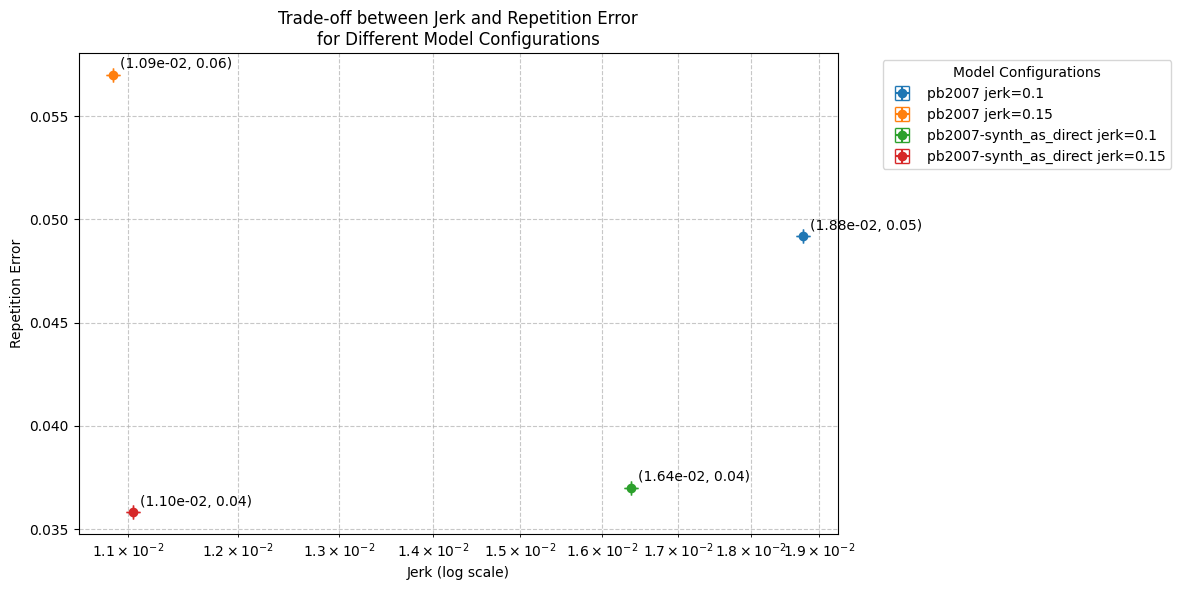

In [40]:
# Define metrics and scales for plotting
plot_metrics = ["inverse_model_jerk", "inverse_model_repetition_error"]
plot_scales = ["log", "linear"]

# Create figure and axis
plt.figure(figsize=(12,6))
ax = plt.subplot()

# Set axis labels and scales
ax.set_xlabel("Jerk (log scale)")
ax.set_ylabel("Repetition Error") 
ax.set_xscale(plot_scales[0])
ax.set_yscale(plot_scales[1])

# Add descriptive title
ax.set_title("Articulatory parameters Jerk and Repetition Error\nfor Different Model Configurations")

# Plot mean metrics for each group
groups_name = groups_metrics[plot_metrics[0]].keys()
print(groups_name)
for group_name in groups_name:
    # Calculate mean values
    x = np.mean(groups_metrics[plot_metrics[0]][group_name])
    y = np.mean(groups_metrics[plot_metrics[1]][group_name])
    
    # Calculate standard error
    x_err = np.std(groups_metrics[plot_metrics[0]][group_name]) / np.sqrt(len(groups_metrics[plot_metrics[0]][group_name]))
    y_err = np.std(groups_metrics[plot_metrics[1]][group_name]) / np.sqrt(len(groups_metrics[plot_metrics[1]][group_name]))
    
    # Plot point with error bars
    ax.errorbar(x, y, xerr=x_err, yerr=y_err, fmt='o', label=group_name, capsize=5)
    
    # Add value annotations
    ax.annotate(f'({x:.2e}, {y:.2f})', 
                (x, y), 
                xytext=(5, 5), 
                textcoords='offset points')

# Add legend with descriptive title
ax.legend(title="Model Configurations", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid for better readability
ax.grid(True, which='both', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()


Group: pb2007 jerk=0.1
Mean inverse_model_repetition_error: 0.049
Std inverse_model_repetition_error: 0.000
Number of samples: 1

Group: pb2007 jerk=0.15
Mean inverse_model_repetition_error: 0.057
Std inverse_model_repetition_error: 0.000
Number of samples: 1


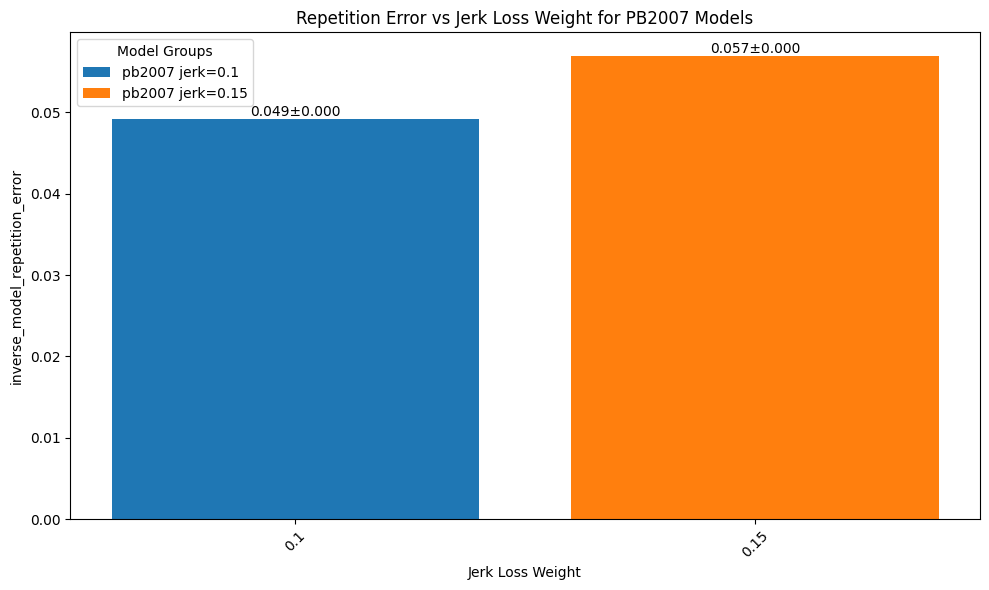

In [32]:
# Define metrics to plot
plot_metrics = ["inverse_model_jerk", "inverse_model_repetition_error"]

# Create figure and axis
plt.figure(figsize=(10, 6))
ax = plt.subplot()

# Set labels and title
ax.set_ylabel(plot_metrics[1])
ax.set_title("Repetition Error vs Jerk Loss Weight for PB2007 Models")

# Get groups and filter for pb2007
groups_name = groups_metrics[plot_metrics[0]].keys()
pb2007_groups = [g for g in groups_name if g.startswith("pb2007 ")]

# Plot bars and add value labels
for i_group, group_name in enumerate(pb2007_groups):
    # Get mean and std of metrics
    mean_val = np.mean(groups_metrics[plot_metrics[1]][group_name])
    std_val = np.std(groups_metrics[plot_metrics[1]][group_name])
    
    # Plot bar with error bar
    ax.bar(i_group, mean_val, yerr=std_val, label=group_name)
    
    # Add value label on top of bar
    ax.text(i_group, mean_val + std_val, f'{mean_val:.3f}±{std_val:.3f}', 
            ha='center', va='bottom')

    # Print statistics
    print(f"\nGroup: {group_name}")
    print(f"Mean {plot_metrics[1]}: {mean_val:.3f}")
    print(f"Std {plot_metrics[1]}: {std_val:.3f}")
    print(f"Number of samples: {len(groups_metrics[plot_metrics[1]][group_name])}")

# Adjust legend and display
ax.legend(title="Model Groups")
plt.xticks(range(len(pb2007_groups)), [g.split('jerk=')[1] for g in pb2007_groups], rotation=45)
ax.set_xlabel("Jerk Loss Weight")
plt.tight_layout()
plt.show()